In [1]:
!pip install fastai

In [4]:
import fastai
import torch

In [5]:
from fastcore.all import *
from fastdownload import download_url
import time

from fastai.vision.all import *
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
?download_images

In [ ]:
# Using search images 

In [2]:
def search_images(term, max_images=200):
        url = 'https://duckduckgo.com/'
        res = urlread(url, data={'q':term})
        searchObj = re.search(r'vqd=([\d-]+)\&', res)
        requestUrl = url + 'i.js'
        params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f='...', p='1', v7exp='a')
        urls, data = set(), {'next':1}
        while len(urls)<max_images and 'next' in data:
            data = urljson(requestUrl, data=params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
            time.sleep(0.2)
        return L(urls)[:max_images]

In [13]:
terms = ['hotdog', 'pasta', 'pizza', 'salad', 'sandwich']
i = 4
urls = search_images(terms[i])

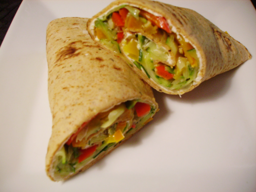

In [14]:
dest = f'{terms[i]}.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

In [9]:
searches = 'hotdog', 'pasta', 'pizza', 'salad', 'sandwich'
path = Path('hotdogData')

for o in searches:
    dest = (path/o)
    if os.path.exists(dest) == False:
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} photo'), max_pics=200)
        resize_images(path/o, max_size=400, dest=path/o)                  

In [10]:
# Manual
class HotDogDataset(Dataset):
    def __init__(self, searches, transform):
        self.path = Path('hotdogData')
        self.list_paths = []
        for tag in searches:
            if (os.path.exists(path/tag)) & (tag.endswith('jpg')==False):
                tags_dir = os.listdir(path/tag)
                tags_dir = [f'{path/tag/t}' for t in tags_dir if 'checkpoints' not in t ]
                self.list_paths.extend(tags_dir)

    def __len__(self):
        return len(self.list_paths)
    
    def __getitems__(self, index):
        dest = self.list_paths[index]
        x = Image.open(dest)
        y = dest.split(os.sep)[1]
        print(y)
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
    transforms.ToTensor(),
])

dt = HotDogDataset(searches, transform=transform)

delete_images = verify_images(dt.list_paths)

print(f'deleting {len(delete_images)}')
for d_img in delete_images:
    Path(d_img).unlink()

train_size = int(0.8 * len(dt))
test_size = len(dt) - train_size

train_dataset, test_dataset = random_split(dt, [train_size, test_size])

train_data = DataLoader(dataset=train_dataset, batch_size=6, shuffle=True)

deleting 0


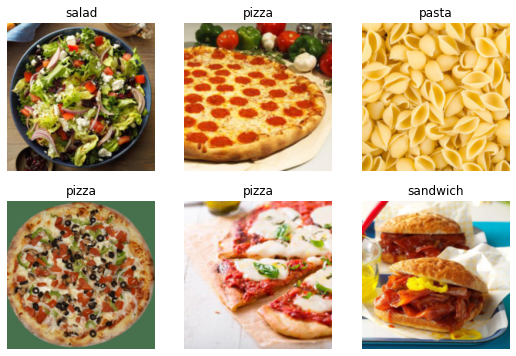

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/aina/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aina/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.493643,0.337268,0.104972,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.447411,0.276121,0.060773,00:32
1,0.327933,0.262554,0.066298,00:31
2,0.233476,0.243872,0.055249,00:32


In [13]:
y_pred, _, probs = learn.predict(PILImage.create('hotdog.jpg'))

print(searches[np.argmax(probs)], probs)

pasta tensor([2.4650e-01, 7.5299e-01, 9.8423e-05, 6.0717e-05, 3.5027e-04])


In [14]:
learn.export('hotdog.pkl')